In [279]:
import numpy as np
import os
from skimage import io
import glob,string
import pandas as pd
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.datasets import mnist
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [329]:
path = 'Data/coil-20-proc/coil-20-proc/*.png'
#list files
files=glob.glob(path)

In [330]:
import codecs
from tqdm import tqdm
def contructDataframe(file_list):
    """
    this function builds a data frame which contains 
    the path to image and the tag/object name using the prefix of the image name
    """
    data=[]
    for file in tqdm(file_list):
        data.append((file,file.split("/")[-1].split("__")[0]))
    return pd.DataFrame(data,columns=['path','label'])

In [331]:
df=contructDataframe(files)


100%|██████████████████████████████████████████████████████████████████████████| 1440/1440 [00:00<00:00, 480531.29it/s]


In [332]:
df.tail(10)

path              label
1430  Data/coil-20-proc/coil-20-proc\obj9__65.png  coil-20-proc\obj9
1431  Data/coil-20-proc/coil-20-proc\obj9__66.png  coil-20-proc\obj9
1432  Data/coil-20-proc/coil-20-proc\obj9__67.png  coil-20-proc\obj9
1433  Data/coil-20-proc/coil-20-proc\obj9__68.png  coil-20-proc\obj9
1434  Data/coil-20-proc/coil-20-proc\obj9__69.png  coil-20-proc\obj9
1435   Data/coil-20-proc/coil-20-proc\obj9__7.png  coil-20-proc\obj9
1436  Data/coil-20-proc/coil-20-proc\obj9__70.png  coil-20-proc\obj9
1437  Data/coil-20-proc/coil-20-proc\obj9__71.png  coil-20-proc\obj9
1438   Data/coil-20-proc/coil-20-proc\obj9__8.png  coil-20-proc\obj9
1439   Data/coil-20-proc/coil-20-proc\obj9__9.png  coil-20-proc\obj9

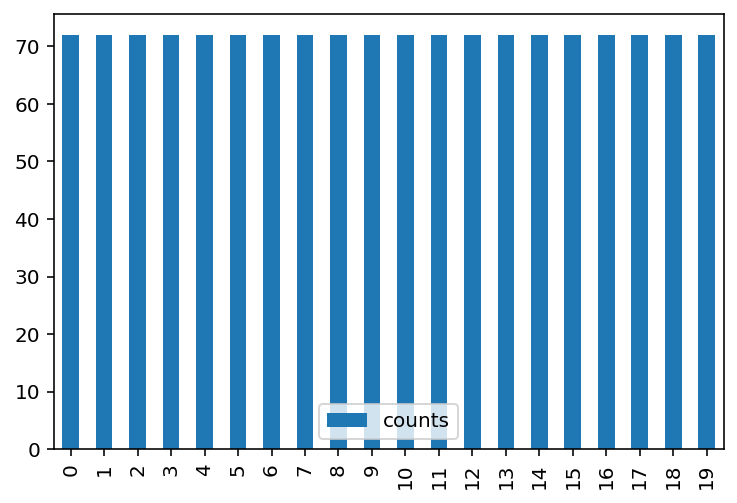

In [333]:
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
counts=df.groupby(df.label).size().reset_index(name="counts")
counts.plot.bar()

In [334]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.path, df.label, test_size=0.20,random_state=0,stratify= df.label)


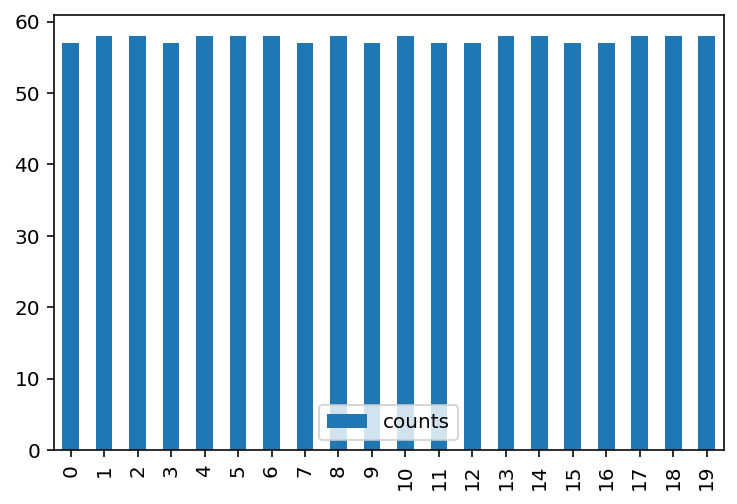

In [335]:
X_train.groupby(y_train).size().reset_index(name="counts").plot.bar()


In [336]:
from keras.preprocessing.image import load_img,img_to_array
from tqdm import tqdm

from skimage import io

X_train=[img_to_array(io.imread(file).astype("float")/255.0) for file in tqdm(X_train.values)]

100%|█████████████████████████████████████████████████████████████████████████████| 1152/1152 [00:01<00:00, 793.93it/s]


In [337]:
X_test=[img_to_array(io.imread(file).astype("float")/255.0) for file in tqdm(X_test.values)]

100%|███████████████████████████████████████████████████████████████████████████████| 288/288 [00:00<00:00, 786.50it/s]


In [338]:
X_train=np.array(X_train)
X_test=np.array(X_test)


In [339]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.2,random_state=0, stratify= y_train)

In [340]:
X_train.shape

(921, 128, 128, 1)

In [341]:
X_validation.shape

(231, 128, 128, 1)

In [342]:
X_test.shape

(288, 128, 128, 1)

In [343]:
X_test = X_test.reshape((288,128,128))
X_train = X_train.reshape((921,128,128))
X_validation = X_validation.reshape((231,128,128))

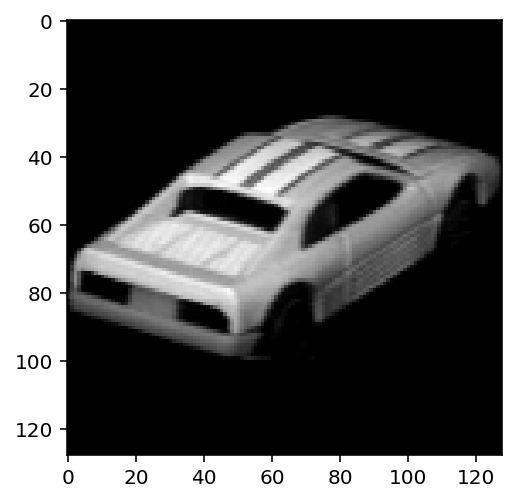

In [344]:
#X_test = X_test.reshape(-1, 128, 128,1)
import matplotlib.pyplot as plt

img = X_test[0]
plt.imshow(img)
plt.show()

In [345]:
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
X_validation = X_validation.reshape((len(X_validation), np.prod(X_validation.shape[1:])))

In [346]:
len(X_test)

288

In [347]:
X_test.shape

(288, 16384)

In [348]:
X_train.shape

(921, 16384)

In [349]:
X_validation.shape

(231, 16384)

In [350]:
X_train_copy = X_train
X_test_copy = X_test
X_validation_copy = X_validation

# Auto encoder 

In [351]:
# this is the size of our encoded representations
encoding_dim = 1024  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(16384,))

# "encoded" is the encoded representation of the input
encoded = Dense(4096, activation='relu')(input_img)
encoded1 = Dense(encoding_dim, activation='relu')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(4096, activation='sigmoid')(encoded1)
decoded1 = Dense(16384, activation='sigmoid')(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded1)

# intermediate result
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded1)

autoencoder.compile(optimizer='adam', loss='mse' )

In [303]:
autoencoder.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 16384)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 4096)              67112960  
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              4195328   
_________________________________________________________________
dense_21 (Dense)             (None, 4096)              4198400   
_________________________________________________________________
dense_22 (Dense)             (None, 16384)             67125248  
Total params: 142,631,936
Trainable params: 142,631,936
Non-trainable params: 0
_________________________________________________________________


In [352]:
print("Computing Encoding Representation")
history =autoencoder.fit(X_train, X_train,
                epochs=30,
                batch_size=256,
                shuffle=True,
               )
result = autoencoder.evaluate(X_validation, X_validation)

Computing Encoding Representation
Epoch 1/30
921/921 [==============================] - ETA: 34s - loss: 0.14 - ETA: 18s - loss: 0.11 - ETA: 6s - loss: 0.1003 - 39s 42ms/step - loss: 0.0960
Epoch 2/30
921/921 [==============================] - ETA: 20s - loss: 0.06 - ETA: 12s - loss: 0.06 - ETA: 4s - loss: 0.0685 - 29s 32ms/step - loss: 0.0675
Epoch 3/30
921/921 [==============================] - ETA: 30s - loss: 0.06 - ETA: 15s - loss: 0.05 - ETA: 6s - loss: 0.0583 - 39s 43ms/step - loss: 0.0574
Epoch 4/30
921/921 [==============================] - ETA: 36s - loss: 0.05 - ETA: 18s - loss: 0.05 - ETA: 6s - loss: 0.0505 - 41s 45ms/step - loss: 0.0497
Epoch 5/30
921/921 [==============================] - ETA: 27s - loss: 0.04 - ETA: 16s - loss: 0.04 - ETA: 6s - loss: 0.0459 - 39s 42ms/step - loss: 0.0455
Epoch 6/30
921/921 [==============================] - ETA: 30s - loss: 0.04 - ETA: 17s - loss: 0.04 - ETA: 7s - loss: 0.0431 - 43s 47ms/step - loss: 0.0434
Epoch 7/30
921/921 [==========

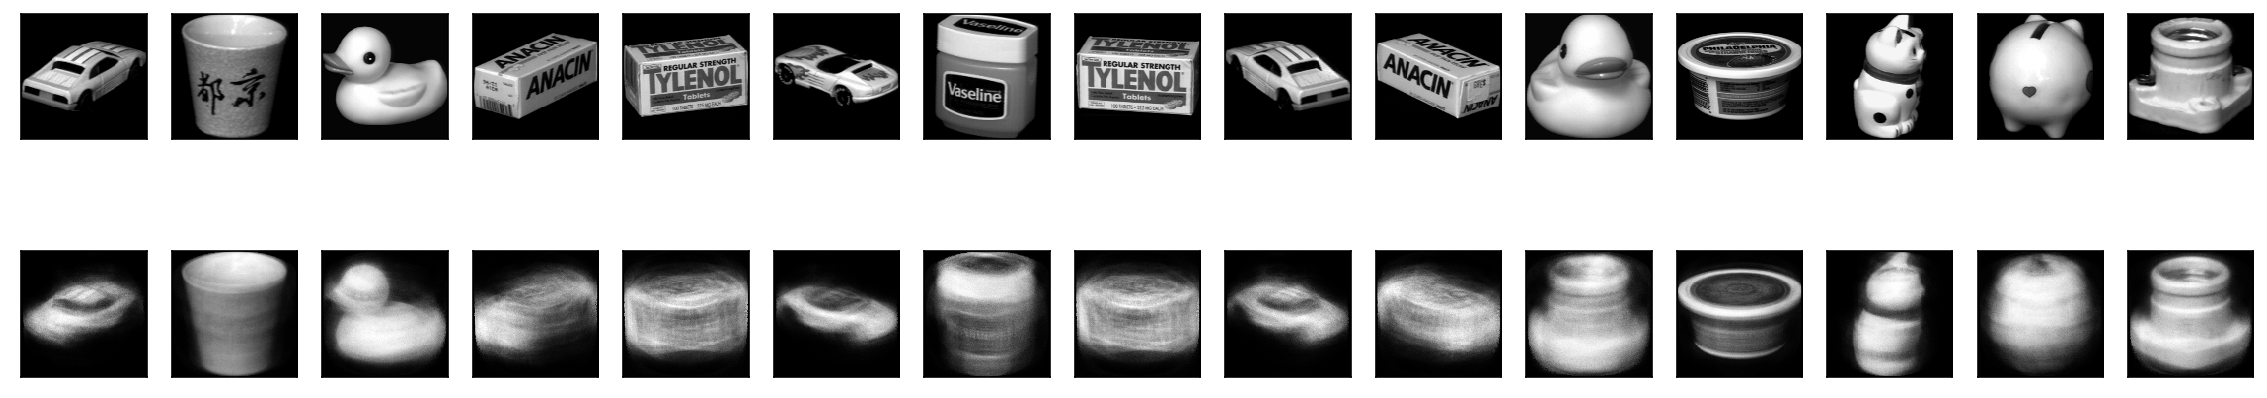

In [353]:
reconst_test = autoencoder.predict(X_test)
encode_test = encoder.predict(X_test)

n = 15
row = 2

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(row, n, i + 1)
    plt.imshow(X_test[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(row, n, i + 1 + n)
    plt.imshow(reconst_test[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

# LLE

In [355]:
X = encode_test
Y= 'gray'
n_neighbors = 20
print("Computing LLE embedding")
a = LocallyLinearEmbedding(n_components=2, n_neighbors=30)
data_2= a.fit_transform(X)
print("Done. Reconstruction error: %g" % a.reconstruction_error_)

Computing LLE embedding
Done. Reconstruction error: 1.12231e-06


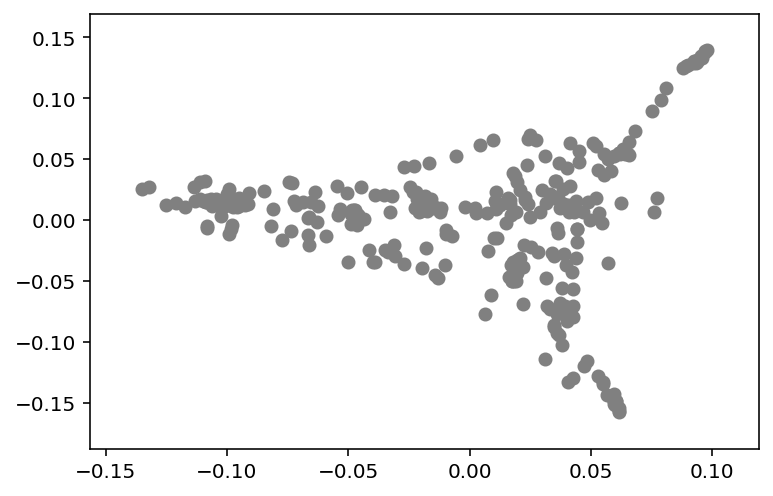

In [356]:
plt.scatter(data_2[:, 0], data_2[:, 1], c = Y)
plt.savefig("LLE_Coil20.png")
plt.show()

In [357]:
from matplotlib import offsetbox

def plot_components(data, proj, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()    
    
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

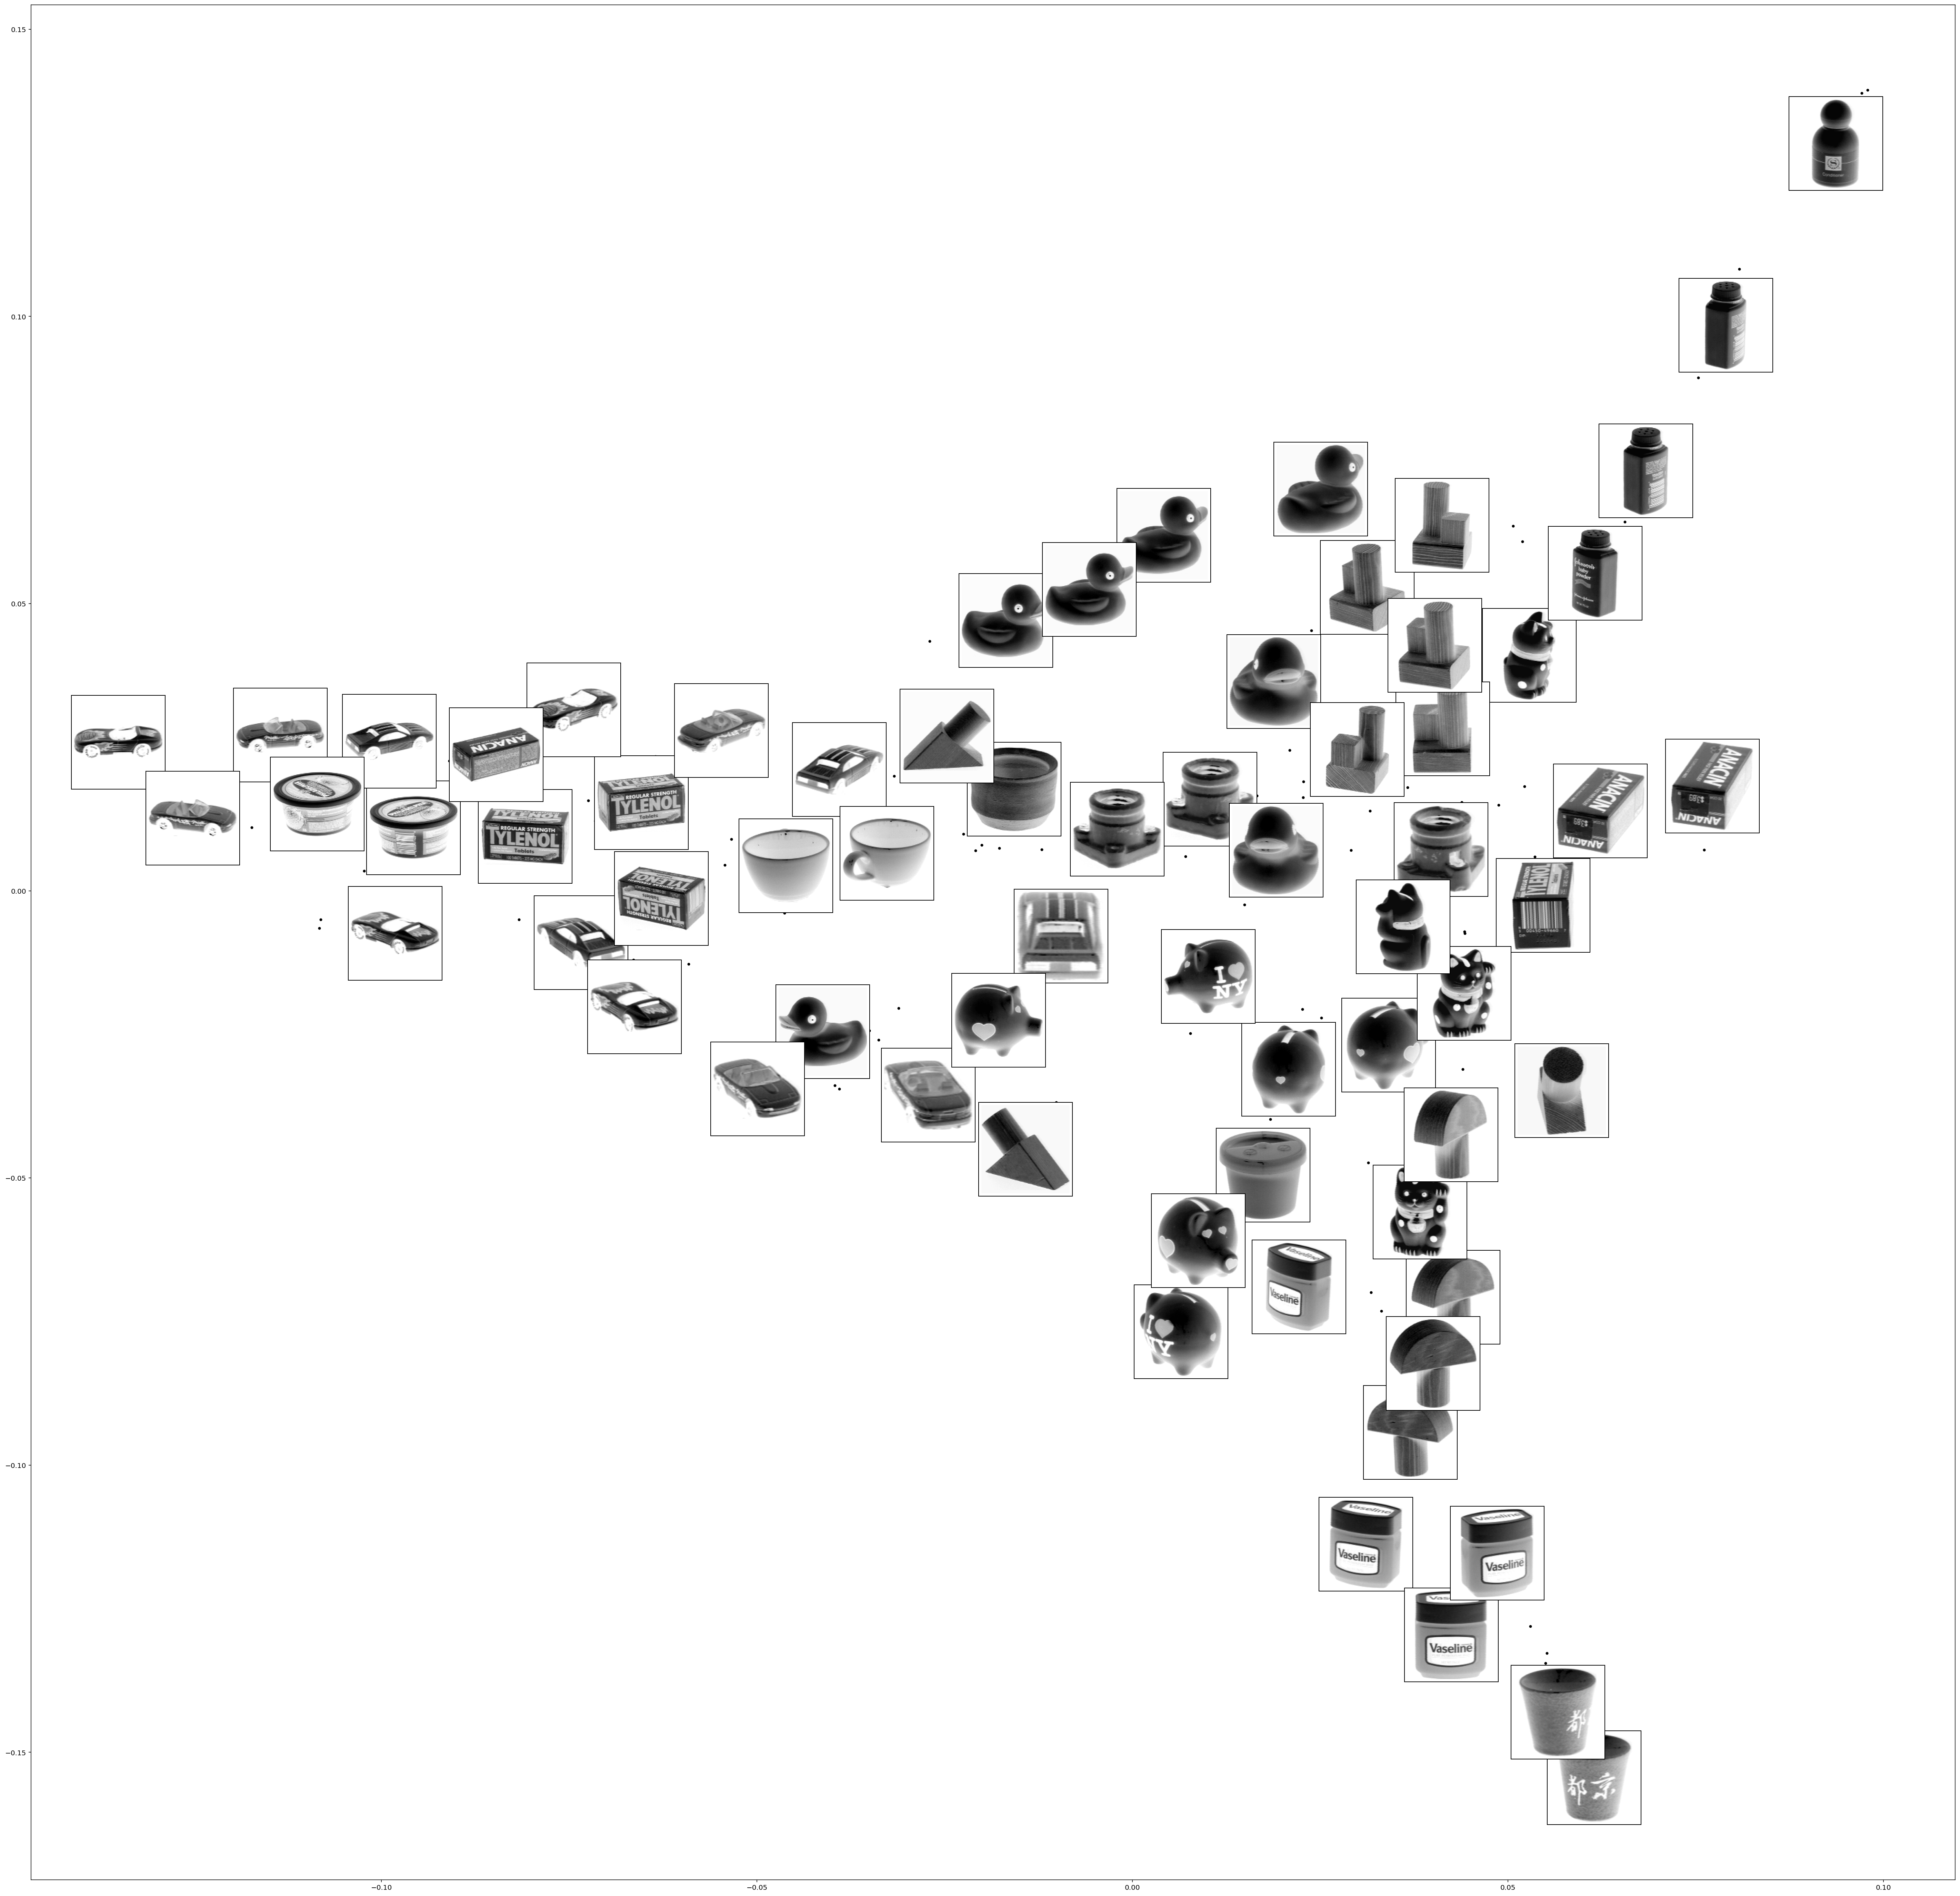

In [358]:
fig, ax = plt.subplots(figsize=(50, 50))

plot_components(encode_test,data_2, images=X_test.reshape((-1, 128, 128)),
                ax=ax, thumb_frac=0.04, cmap='gray_r')

# Loss Functions

In [360]:
def autoencoder_loss(X, reconstructed_X):
    return np.square(np.subtract(X, reconstructed_X)).mean()

In [361]:
def mse_objective(autoencoder_loss, lle_loss, lamda = 0.02):
    return autoencoder_loss + lamda*lle_loss

In [362]:
ae_loss = autoencoder_loss(X_test,reconst_test)
ae_loss

0.01616602

In [363]:
lle_loss=a.reconstruction_error_
lle_loss

1.122313317129264e-06

In [364]:
global_mse = mse_objective(ae_loss, lle_loss)
global_mse

0.016166042631021667

In [365]:
encode_test_copy = encode_test
a_copy = a

# Combination AE & LLE

In [366]:
mse = []
ae_mse = []
lle_mse = []
mse.append(global_mse)
ae_mse.append(ae_loss)
lle_mse.append(lle_loss)



In [367]:
mse[0]

0.016166042631021667

In [369]:
improv

0.0

In [385]:
iterations = 3
cmp = 30
improv =  1
while (improv > 0.0001)  and (global_mse > 0.001) and (iterations < cmp):
    print ('Itérations :', iterations + 1)
    #reload the data
    X_train = X_train_copy
    X_test = X_test_copy
    #Update AE params
    print ('Start Autoencoder')
    history =autoencoder.fit(X_train, X_train,
                epochs=30,
                batch_size=256)
    result = autoencoder.evaluate(X_test, X_test)
    reconst_test = autoencoder.predict(X_test)
    encode_test = encoder.predict(X_test)
    
    #Update LLE weights
    #a = LocallyLinearEmbedding(n_components=2, n_neighbors=30)
    print ('Start LLE')
    data_2= a.fit_transform( encode_test)
    
    #Calculate global mse
    lle_loss=a.reconstruction_error_
    ae_loss = autoencoder_loss(X_test,reconst_test)
    global_mse = mse_objective(ae_loss, lle_loss)
    lle_mse.append(lle_loss)
    ae_mse.append(ae_loss)
    mse.append(global_mse)
    improv =  mse[iterations] - global_mse
    iterations =iterations +1
    print ('AE loss : ', ae_loss)
    print ('LLE loss : ', lle_loss)
    print ('Global loss : ', global_mse)

Itérations : 4
Start Autoencoder
Epoch 1/30
921/921 [==============================] - ETA: 19s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 4s - loss: 0.0033 - 27s 29ms/step - loss: 0.0034
Epoch 2/30
921/921 [==============================] - ETA: 18s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 4s - loss: 0.0033 - 26s 28ms/step - loss: 0.0034
Epoch 3/30
921/921 [==============================] - ETA: 17s - loss: 0.00 - ETA: 11s - loss: 0.00 - ETA: 4s - loss: 0.0034 - 28s 31ms/step - loss: 0.0033
Epoch 4/30
921/921 [==============================] - ETA: 21s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 5s - loss: 0.0033 - 31s 34ms/step - loss: 0.0033
Epoch 5/30
921/921 [==============================] - ETA: 25s - loss: 0.00 - ETA: 14s - loss: 0.00 - ETA: 6s - loss: 0.0033 - 37s 40ms/step - loss: 0.0033
Epoch 6/30
921/921 [==============================] - ETA: 30s - loss: 0.00 - ETA: 16s - loss: 0.00 - ETA: 5s - loss: 0.0033 - 36s 39ms/step - loss: 0.0033
Epoch 7/30
921/921 [===========

921/921 [==============================] - ETA: 36s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 9s - loss: 0.0022 - 61s 66ms/step - loss: 0.0022
Epoch 22/30
921/921 [==============================] - ETA: 47s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 9s - loss: 0.0022 - 60s 65ms/step - loss: 0.0022
Epoch 23/30
921/921 [==============================] - ETA: 33s - loss: 0.00 - ETA: 24s - loss: 0.00 - ETA: 8s - loss: 0.0021 - 53s 57ms/step - loss: 0.0022
Epoch 24/30
921/921 [==============================] - ETA: 26s - loss: 0.00 - ETA: 20s - loss: 0.00 - ETA: 7s - loss: 0.0021 - 47s 51ms/step - loss: 0.0021
Epoch 25/30
921/921 [==============================] - ETA: 33s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 8s - loss: 0.0021 - 49s 54ms/step - loss: 0.0021
Epoch 26/30
921/921 [==============================] - ETA: 38s - loss: 0.00 - ETA: 25s - loss: 0.00 - ETA: 8s - loss: 0.0021 - 54s 58ms/step - loss: 0.0021
Epoch 27/30
921/921 [==============================] - ETA: 40s - loss

921/921 [==============================] - ETA: 36s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 7s - loss: 0.0015 - 47s 51ms/step - loss: 0.0015
Epoch 11/30
921/921 [==============================] - ETA: 35s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 7s - loss: 0.0015 - 48s 52ms/step - loss: 0.0015
Epoch 12/30
921/921 [==============================] - ETA: 36s - loss: 0.00 - ETA: 19s - loss: 0.00 - ETA: 7s - loss: 0.0015 - 47s 51ms/step - loss: 0.0015
Epoch 13/30
921/921 [==============================] - ETA: 39s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 8s - loss: 0.0015 - 49s 53ms/step - loss: 0.0015
Epoch 14/30
921/921 [==============================] - ETA: 36s - loss: 0.00 - ETA: 23s - loss: 0.00 - ETA: 8s - loss: 0.0015 - 50s 54ms/step - loss: 0.0015
Epoch 15/30
921/921 [==============================] - ETA: 39s - loss: 0.00 - ETA: 22s - loss: 0.00 - ETA: 9s - loss: 0.0015 - 52s 57ms/step - loss: 0.0015
Epoch 16/30
921/921 [==============================] - ETA: 42s - loss

# Evaluation

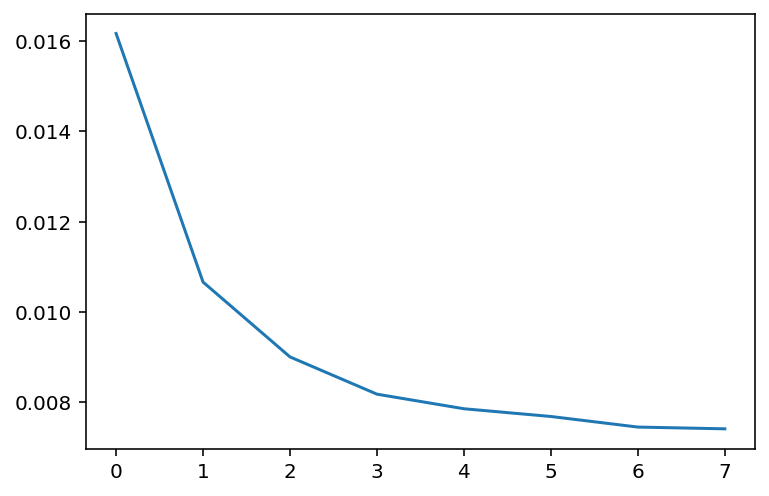

In [386]:
plt.plot(mse)


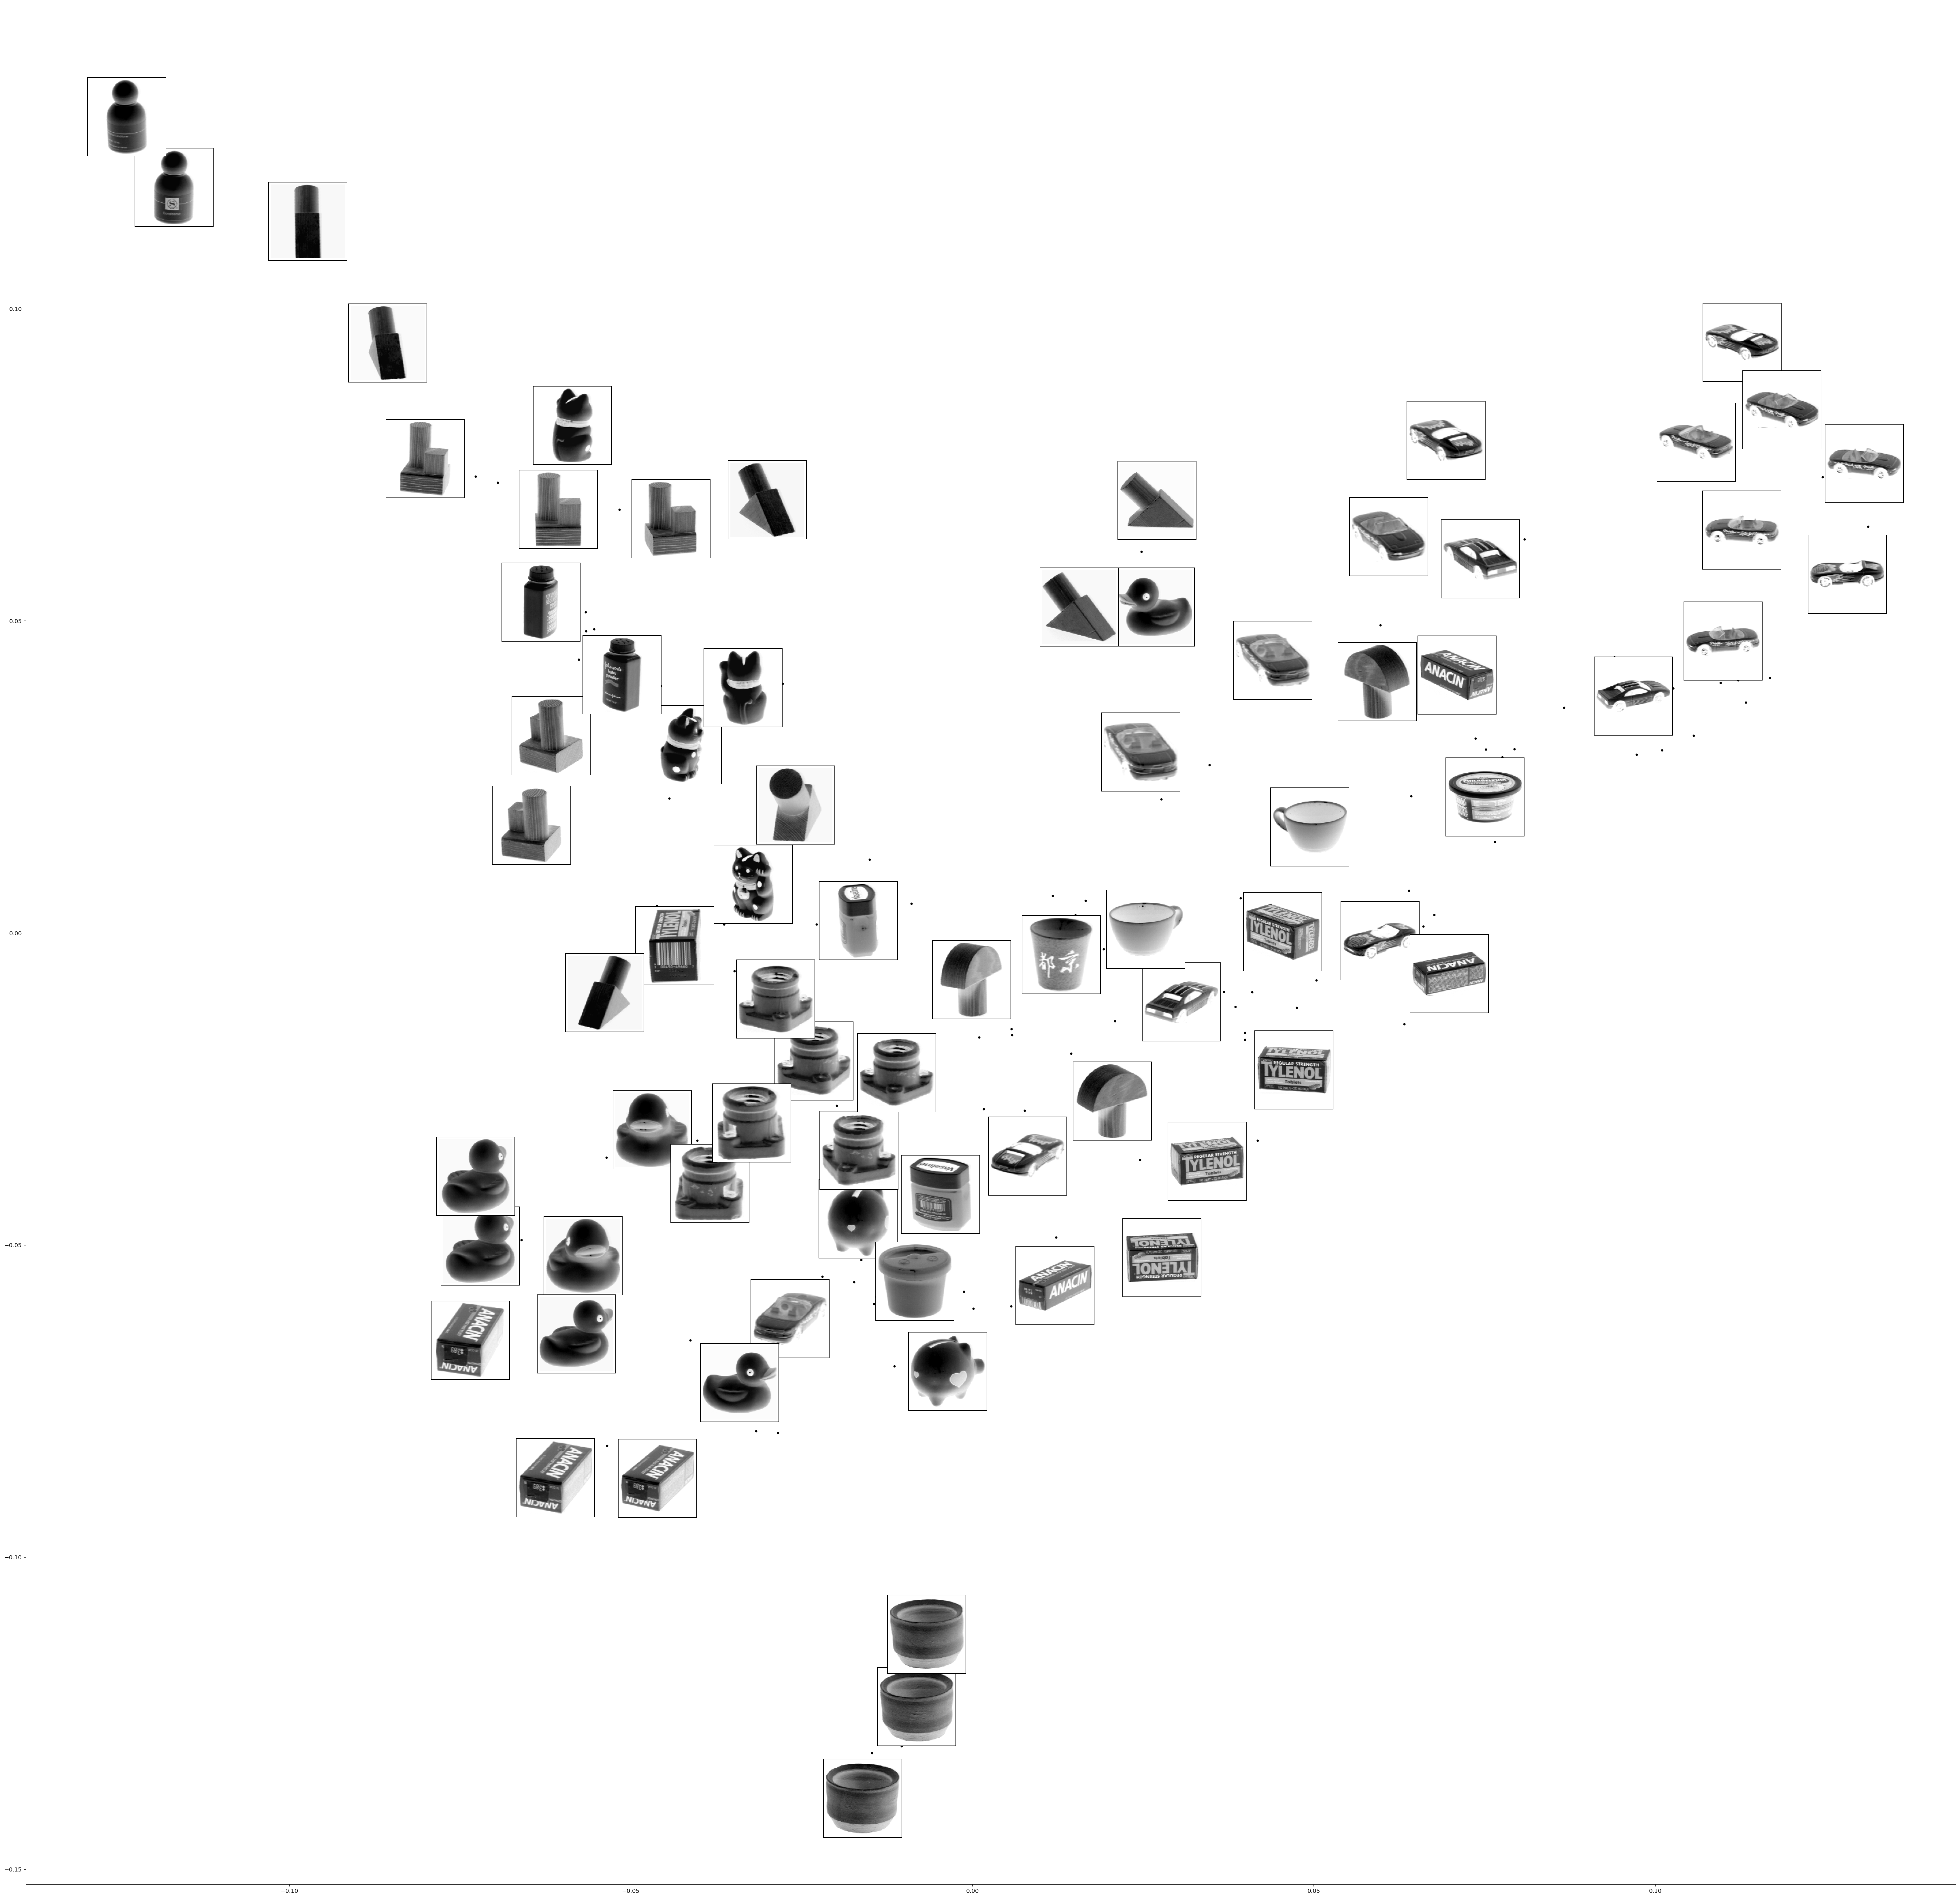

In [402]:
#Clustering & Visualisation
fig, ax = plt.subplots(figsize=(60, 60))
plot_components(encode_test,data_2, images=X_test.reshape((-1, 128, 128)),
                ax=ax, thumb_frac=0.04, cmap='gray_r')

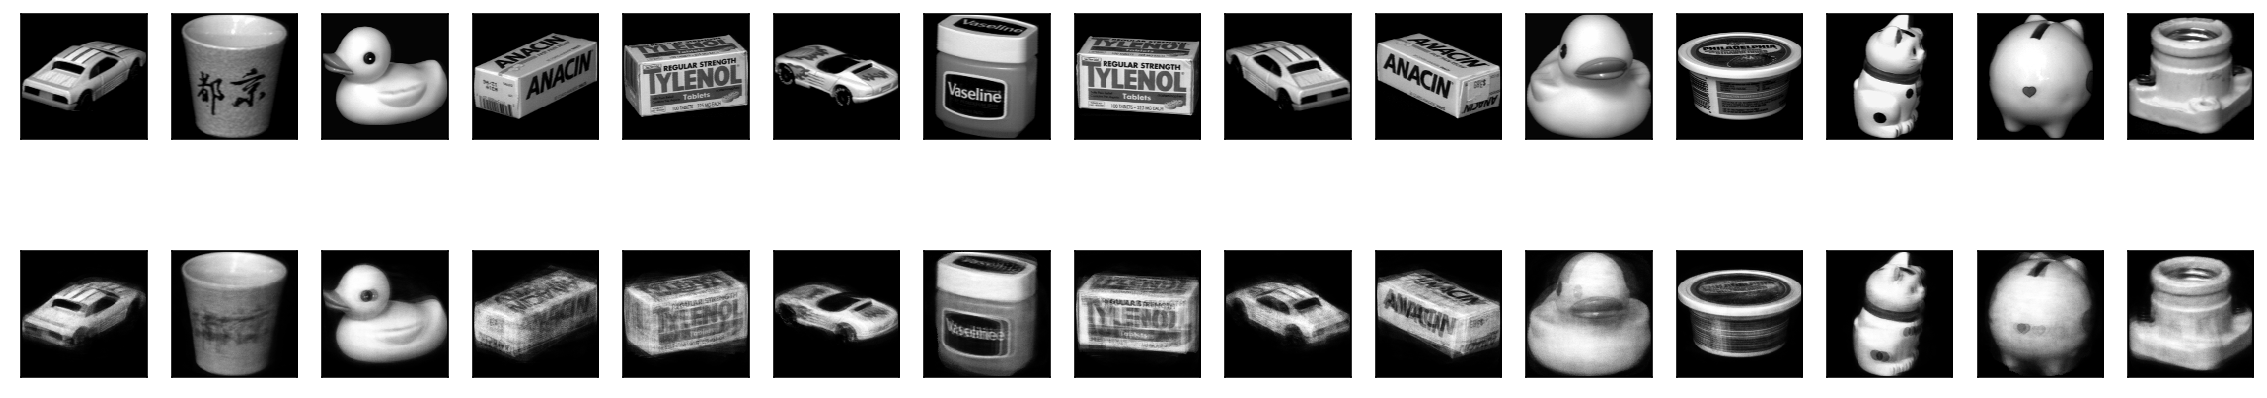

In [389]:
n = 15
row = 2

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(row, n, i + 1)
    plt.imshow(X_test[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(row, n, i + 1 + n)
    plt.imshow(reconst_test[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

# Outputs

In [390]:
#S weights matrix
S=a.nbrs_.kneighbors_graph()
S.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [391]:
# Encoding matrix
f = encode_test
f

array([[  0.       ,   0.       ,  17.848106 , ...,   0.       ,
          0.       ,   0.       ],
       [ 20.597523 ,   0.       ,   6.2833996, ...,   7.492228 ,
         89.30093  ,   0.       ],
       [  0.       ,   0.       ,  57.40408  , ...,  45.467667 ,
         15.8096075, 117.994255 ],
       ...,
       [  0.       ,   0.       ,  23.461002 , ...,  15.808411 ,
         10.828974 ,  34.0088   ],
       [  0.       ,   0.       ,   0.       , ..., 150.45744  ,
         45.570866 ,  90.94292  ],
       [ 22.518093 ,   0.       ,   0.4145909, ...,   0.       ,
         73.45843  ,   0.       ]], dtype=float32)

In [392]:
# Embedding matrix
B = data_2
B

array([[ 3.05970577e-02, -1.10388782e-02],
       [ 1.30215523e-02, -3.43715094e-03],
       [ 2.67914230e-02,  5.22212229e-02],
       [ 1.21059657e-02, -5.64460454e-02],
       [ 3.43763377e-02, -3.65476424e-02],
       [ 1.12691587e-01,  9.46299903e-02],
       [ 1.22372399e-02, -4.87738166e-02],
       [ 4.70805284e-02, -2.19364818e-02],
       [ 7.43823443e-02,  5.99450595e-02],
       [ 7.09699429e-02,  4.13528155e-02],
       [-5.70006422e-02, -5.17057360e-02],
       [ 7.50658380e-02,  2.17924375e-02],
       [-4.24956263e-02,  3.01432933e-02],
       [-1.67490114e-02, -4.57814889e-02],
       [-2.31960555e-02, -2.05078682e-02],
       [ 5.97130230e-02, -1.25012347e-03],
       [-3.00275310e-02,  6.94277274e-02],
       [ 3.14705272e-02, -1.59434513e-02],
       [-6.31666489e-02,  5.30351680e-02],
       [ 7.93599486e-02,  2.94548087e-02],
       [-4.68560207e-02, -3.15525297e-02],
       [-1.60780184e-02, -1.38615595e-01],
       [-5.53741044e-02,  4.86752688e-02],
       [ 9.